# Outlier detection

This notebook analyzes the `swiss_food_composition_database_proc` to see for outlier. Different outlier detection methods are found.

## Load and preprocess the data

In [1]:
import pandas as pd
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
dataset = pd.read_csv('../data/swiss_food_composition_database_proc.csv')

In [3]:
dataset.shape

(1092, 43)

In [4]:
dataset.head()

,ID,name,category,energy_kcal,fat_g,fatty_acids_sat_g,fatty_acids_monounsat_g,fatty_acids_polyunsat_g,cholesterol_mg,carbohydrates_g,...,sodium_mg,chloride_mg,calcium_mg,magnesium_mg,phosphorus_mg,iron_mg,iodide_µg,zinc_mg,selenium_µg,category_new
0,0,Agar Agar,Various/Gelling and binding agents,160.0,0.2,NaN,NaN,NaN,NaN,0.0,...,130.0,NaN,660.0,100.0,34.0,4.5,NaN,1.5,NaN,other
1,1,Agave syrup,Sweets/Sugar and sweeteners,293.0,0.0,0.0,NaN,NaN,NaN,73.1,...,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,sweets
2,2,Almond,"Nuts, seeds and oleaginous fruit",624.0,52.1,4.1,31.4,11.4,0.0,7.8,...,1.1,40.0,270.0,240.0,510.0,3.3,0.2,3.3,2.2,fruits
3,3,"Almond, dry roasted, salted","Savoury snacks/Salted nuts, seeds and kernels",637.0,52.5,4.1,33.1,13.0,0.0,10.1,...,230.0,1190.0,270.0,280.0,470.0,3.7,2.4,3.3,2.0,nuts
4,4,"Almond, roasted, salted","Savoury snacks/Salted nuts, seeds and kernels",649.0,55.2,4.2,34.8,13.5,0.0,7.2,...,330.0,1190.0,240.0,270.0,470.0,3.3,2.4,3.1,2.0,nuts


Remove columns and samples with more than 20% of values missing.

### Remove columns with more than 20% missing values

In [5]:
percentage_present = 0.8
feature_threshold = math.ceil(percentage_present*dataset.shape[0]) # 20% of values missing
feature_threshold

874

In [6]:
columns_before = dataset.columns
dataset = dataset.dropna(axis=1, thresh=feature_threshold)
columns_after = dataset.columns
columns_after

Index(['ID', 'name', 'category', 'energy_kcal', 'fat_g', 'fatty_acids_sat_g',
       'fatty_acids_monounsat_g', 'fatty_acids_polyunsat_g', 'cholesterol_mg',
       'carbohydrates_g', 'sugars_g', 'starch_g', 'fibres_g', 'protein_g',
       'salt_g', 'alcohol_g', 'water_g', 'vit_A_activity_re_µg',
       'vit_A_activity_rae_µg', 'retinol_µg', 'beta_carotene_activity_µg',
       'beta_carotene_µg', 'vit_B1_mg', 'vit_B2_mg', 'vit_B6_mg', 'vit_B12_µg',
       'niacin_mg', 'folate_µg', 'panthotenic_acid_mg', 'vit_c_mg', 'vit_d_µg',
       'vit_e_activity_mg', 'potassium_mg', 'sodium_mg', 'chloride_mg',
       'calcium_mg', 'magnesium_mg', 'phosphorus_mg', 'iron_mg', 'iodide_µg',
       'zinc_mg', 'category_new'],
      dtype='object')

### Remove rows with more than 20% of values missing

In [7]:
row_threshold = math.ceil(percentage_present*dataset.shape[1]) # 20% of values missing
row_threshold

34

In [8]:
rows_before = dataset.index
dataset = dataset.dropna(axis=0, thresh=row_threshold)
rows_after = dataset.index
dataset.shape

(1084, 42)

## Plot to check distributions and outliers

In [9]:
# Create a boolean mask for NaN values
nan_mask = dataset.isna().any(axis=1)

# Create a new DataFrame with samples containing NaN values - we need to save this somewheer in order to perfrom the outlier detection and then re introduce them in the dataset
df_with_nan_only = dataset[nan_mask]

In [10]:
df_with_nan_only.shape

In [53]:
#dataset = dataset.dropna(axis=0) - disable dropping nans
dataset.shape

(1084, 42)

In [12]:
dataset['category_new'].unique()

array(['fruits', 'nuts', 'cereals', 'sweets', 'other', 'dairy',
       'non_alcoholic_beverages', 'vegetables', 'meat', 'herbs', 'sauce',
       'alcoholic_beverages'], dtype=object)

Three food categories disappeared because they always have missing values. So we are performing outlier detetction only on the food categories from above.

In [13]:
dataset['category_new'].value_counts()

other                      228
meat                       187
cereals                    146
vegetables                 127
sweets                     118
dairy                      103
fruits                      99
non_alcoholic_beverages     28
alcoholic_beverages         22
sauce                       16
herbs                        7
nuts                         3
Name: category_new, dtype: int64

In [14]:
dataset.columns

Index(['ID', 'name', 'category', 'energy_kcal', 'fat_g', 'fatty_acids_sat_g',
       'fatty_acids_monounsat_g', 'fatty_acids_polyunsat_g', 'cholesterol_mg',
       'carbohydrates_g', 'sugars_g', 'starch_g', 'fibres_g', 'protein_g',
       'salt_g', 'alcohol_g', 'water_g', 'vit_A_activity_re_µg',
       'vit_A_activity_rae_µg', 'retinol_µg', 'beta_carotene_activity_µg',
       'beta_carotene_µg', 'vit_B1_mg', 'vit_B2_mg', 'vit_B6_mg', 'vit_B12_µg',
       'niacin_mg', 'folate_µg', 'panthotenic_acid_mg', 'vit_c_mg', 'vit_d_µg',
       'vit_e_activity_mg', 'potassium_mg', 'sodium_mg', 'chloride_mg',
       'calcium_mg', 'magnesium_mg', 'phosphorus_mg', 'iron_mg', 'iodide_µg',
       'zinc_mg', 'category_new'],
      dtype='object')

In [15]:
(dataset['vit_B12_µg']<0).any()

False

In [16]:
dict_of_stats = {} # declare the global dictionary here that will collect outlier data

In [17]:
def get_stats(data, outlier_points)->tuple:
    """
    This function will calculate and return the minimum and maximum non_outlier values.

    Args:
        - data: is the data whose statistics are calculated
        - outlier_points: are the outlier points found via the IQR method
    
    Returns:
    a tuple with the minimum and maximum non-outlier points
    """
    # here we get the non outliers
    non_outliers =[x for x in data if x not in outlier_points]

    # here we find the minimum and maximum of the non-outliers
    min_incl = min(non_outliers)
    max_incl = max(non_outliers)
    return (min_incl, max_incl)


def plot_distribution_of_features(dataset:pd.DataFrame, category:str, type:str='hist', plot_title:str="Histogram")->None:
    """
    This function is used to make either a histogram or a boxplot per feature, per food category.
    Args:
        - dataset -  the dataset that we are plotting
        - category - is the food category that we are plotting
        - type - 'hist' for histogram plot and 'box' for boxplot
        - plot_title - 'the title of the plot
    """
    
    category_data = dataset[dataset['category_new'] == category].iloc[:, 3:-1]
    category_data_id = dataset[dataset['category_new'] == category].iloc[:, 0]

    feature_columns = category_data.columns[:-1]
    n_features = len(feature_columns)

    num_rows = (len(feature_columns) - 1) // 5 + 1
    num_cols = min(len(feature_columns), 5)

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 10))

    if num_rows > 1:
        axes = axes.flatten()
    else:
        axes = [axes]

    for i, feature in enumerate(feature_columns):
        ax = axes[i]
        if type=='hist':
            sns.histplot(data=category_data, x=feature, kde=False, ax=ax)
            counts, _, _ = ax.hist(category_data[feature], bins='auto', density=False)
            max_count = max(counts)
            x_min = 0
            x_max = category_data[feature].max()
            ax.set_xlim(x_min, x_max+0.5) 
            ax.set_ylim(0, max_count+3) 
        
        elif type=='box':
            sns.boxplot(x=category_data[feature], ax=ax)
            stats = ax.get_children()[6].get_data()
            outlier_points = stats[0]
            # here we save the outliers' indices in a set so that we can either remove or reset them later
            outlier_indices = [np.where(category_data == outlier)[0][0] for outlier in outlier_points]
            real_indices = category_data_id.iloc[outlier_indices] # calculate the indices corresponding to the complete dataset
            outlier_data = list(zip(outlier_points, real_indices))
            bounds = get_stats(category_data[feature], outlier_points) # find non-outlier min and max values
            dict_of_stats[(category, feature)] = (bounds, outlier_data) # save everything in the global dictionary
        
        ax.set_title(feature)
        ax.set_xlabel('')

    for j in range(n_features, num_rows * num_cols):
        fig.delaxes(axes[j]) # remove empty axes in the end


    fig.suptitle(f'{plot_title} - {category}', fontsize=16)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


### Density plots

In [18]:
#plot_distribution_of_features(dataset, 'fruits')

In [19]:
#plot_distribution_of_features(dataset, 'other')

In [20]:
#plot_distribution_of_features(dataset, 'cereals')

In [21]:
#plot_distribution_of_features(dataset, 'meat')

In [22]:
#plot_distribution_of_features(dataset, 'vegetables')

In [23]:
#plot_distribution_of_features(dataset, 'sweets')

In [24]:
#plot_distribution_of_features(dataset, 'dairy')

In [25]:
#plot_distribution_of_features(dataset, 'fruits')

In [26]:
#plot_distribution_of_features(dataset, 'alcoholic_beverages')

In [27]:
#plot_distribution_of_features(dataset, 'alcoholic_beverages')

In [28]:
#plot_distribution_of_features(dataset, 'sauce')

In [29]:
#plot_distribution_of_features(dataset, 'herbs')

In [30]:
#plot_distribution_of_features(dataset, 'nuts')

In [31]:
#plot_distribution_of_features(dataset, 'non_alcoholic_beverages')

In [32]:
# category_data = dataset[dataset['category_new'] == 'fruits'].iloc[:, 3:-1]
# category_data

In [33]:
# category_data = dataset[dataset['category_new'] == 'non_alcoholic_beverages'].iloc[:, 3:-1]

# sns.histplot(data=category_data, x='energy_kcal', kde=True)

In [34]:
#category_data['alcohol_g'].max()

### Boxplots to check outliers

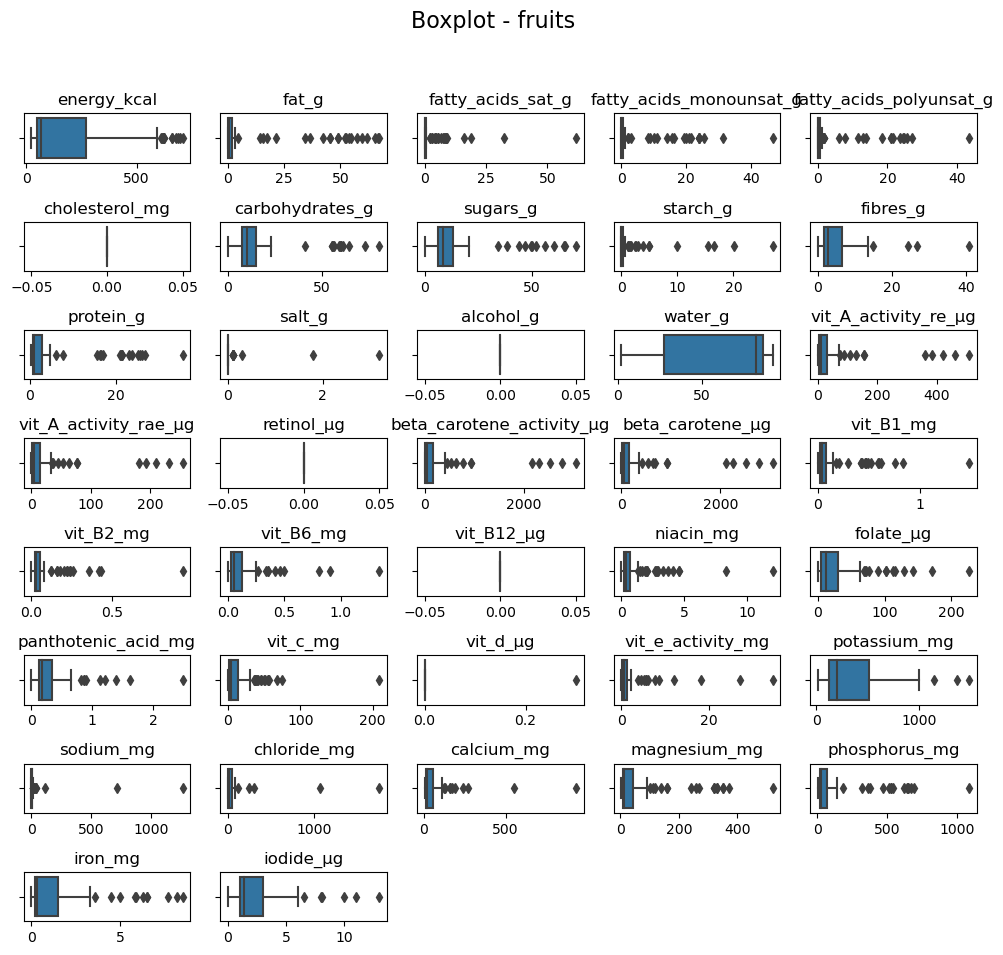

In [35]:
plot_distribution_of_features(dataset, 'fruits', type='box', plot_title='Boxplot')

In [36]:
dataset[dataset['category_new'] == 'fruits']

,ID,name,category,energy_kcal,fat_g,fatty_acids_sat_g,fatty_acids_monounsat_g,fatty_acids_polyunsat_g,cholesterol_mg,carbohydrates_g,...,potassium_mg,sodium_mg,chloride_mg,calcium_mg,magnesium_mg,phosphorus_mg,iron_mg,iodide_µg,zinc_mg,category_new
2,2,Almond,"Nuts, seeds and oleaginous fruit",624.0,52.1000,4.1000,31.4000,11.4000,0.0,7.8,...,740.0,1.1000,40.0000,270.0,240.0,510.0,3.3,0.2,3.3,fruits
14,14,"Apple, fresh",Fruit/Fresh fruit,52.0,0.3000,0.1000,0.0000,0.2000,0.0,11.6,...,120.0,1.5000,61.0000,5.3,6.5,14.0,0.1,0.8,0.1,fruits
15,15,"Apple, peeled, dried",Fruit/Dried fruit,264.0,1.6000,0.7000,0.1000,0.9000,0.0,55.4,...,620.0,10.0000,9.0000,30.0,23.0,50.0,1.2,4.1,0.2,fruits
16,16,"Apple, stewed, drained (without addition of su...",Fruit/Cooked fruit (incl. cans),56.0,0.3000,0.1000,0.0000,0.2000,0.0,12.2,...,94.0,1.2000,80.0000,6.7,6.8,15.0,0.1,1.1,0.1,fruits
17,17,"Applesauce, sweetened, canned",Fruit/Cooked fruit (incl. cans),89.0,0.3000,0.1000,0.0000,0.1000,0.0,20.5,...,97.0,3.6000,2.1000,4.4,3.6,8.1,0.2,0.7,0.1,fruits
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
914,914,"Strawberry, fresh",Fruit/Fresh fruit,39.0,0.5000,0.0001,0.0001,0.0001,0.0,6.0,...,140.0,1.0000,62.0000,18.0,12.0,23.0,0.2,1.0,0.1,fruits
923,923,Sunflower seeds,"Nuts, seeds and oleaginous fruit",621.0,54.5000,5.4000,19.8000,23.5000,0.0,3.6,...,750.0,3.6000,50.0000,86.0,330.0,670.0,5.0,4.0,5.8,fruits
1020,1020,Walnut,"Nuts, seeds and oleaginous fruit",709.0,67.3000,6.5000,14.1000,43.6000,0.0,6.9,...,420.0,0.2000,23.0000,78.0,140.0,360.0,2.6,5.0,2.7,fruits
1025,1025,"Watermelon, fresh",Fruit/Fresh fruit,37.0,0.0001,0.0001,0.0001,0.0001,0.0,8.3,...,100.0,0.0001,8.3000,6.0,11.0,9.7,0.2,10.0,0.1,fruits


In [37]:
dict_of_stats[('fruits', 'energy_kcal')][1]

[(624.0, 2),
 (698.0, 111),
 (681.0, 234),
 (661.0, 422),
 (623.0, 611),
 (688.0, 634),
 (615.0, 726),
 (612.0, 854),
 (619.0, 863),
 (660.0, 169),
 (621.0, 923),
 (709.0, 1020)]

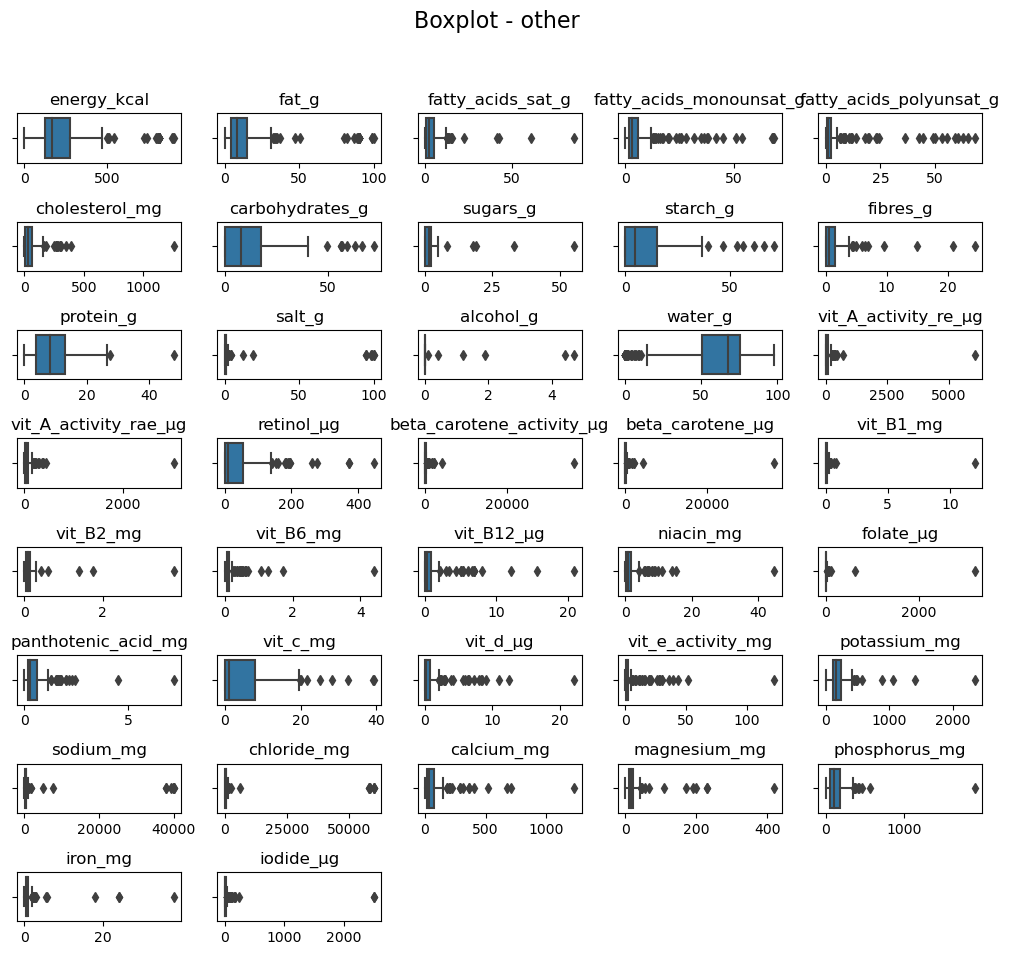

In [38]:
plot_distribution_of_features(dataset, 'other', type='box', plot_title='Boxplot')

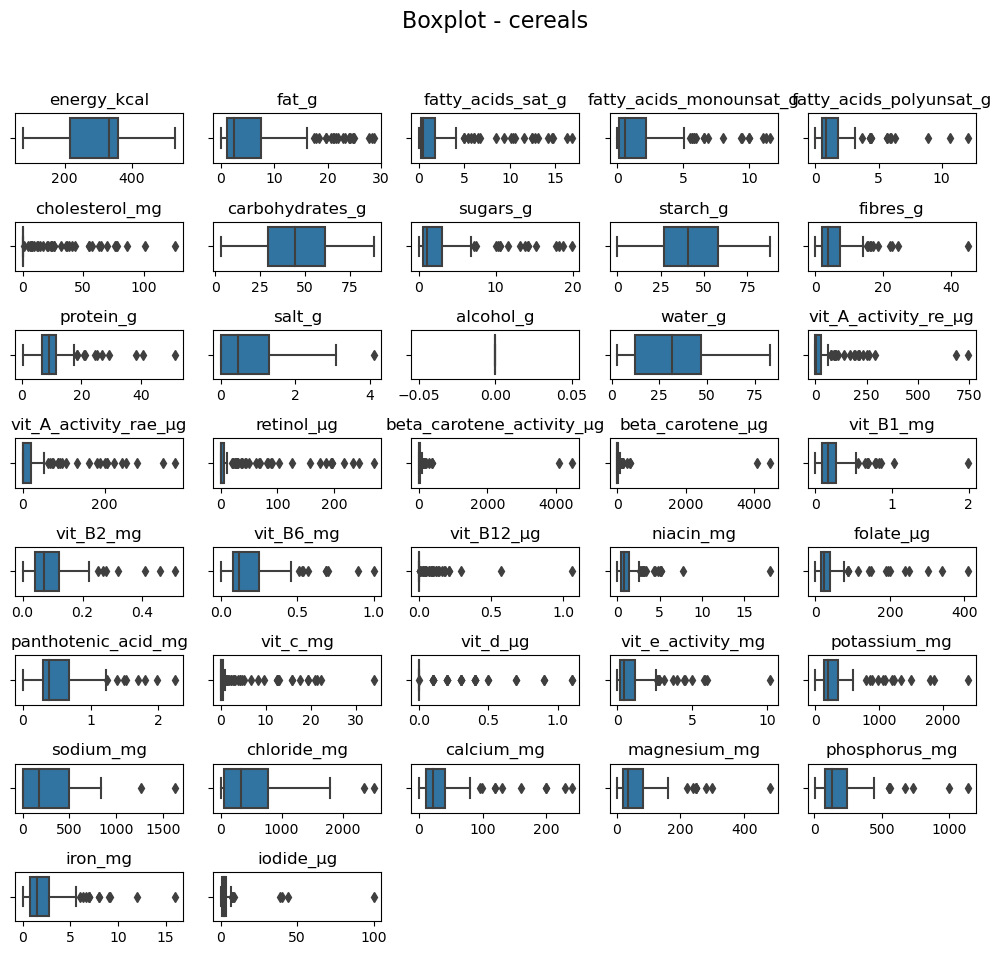

In [39]:
plot_distribution_of_features(dataset, 'cereals', type='box', plot_title='Boxplot')

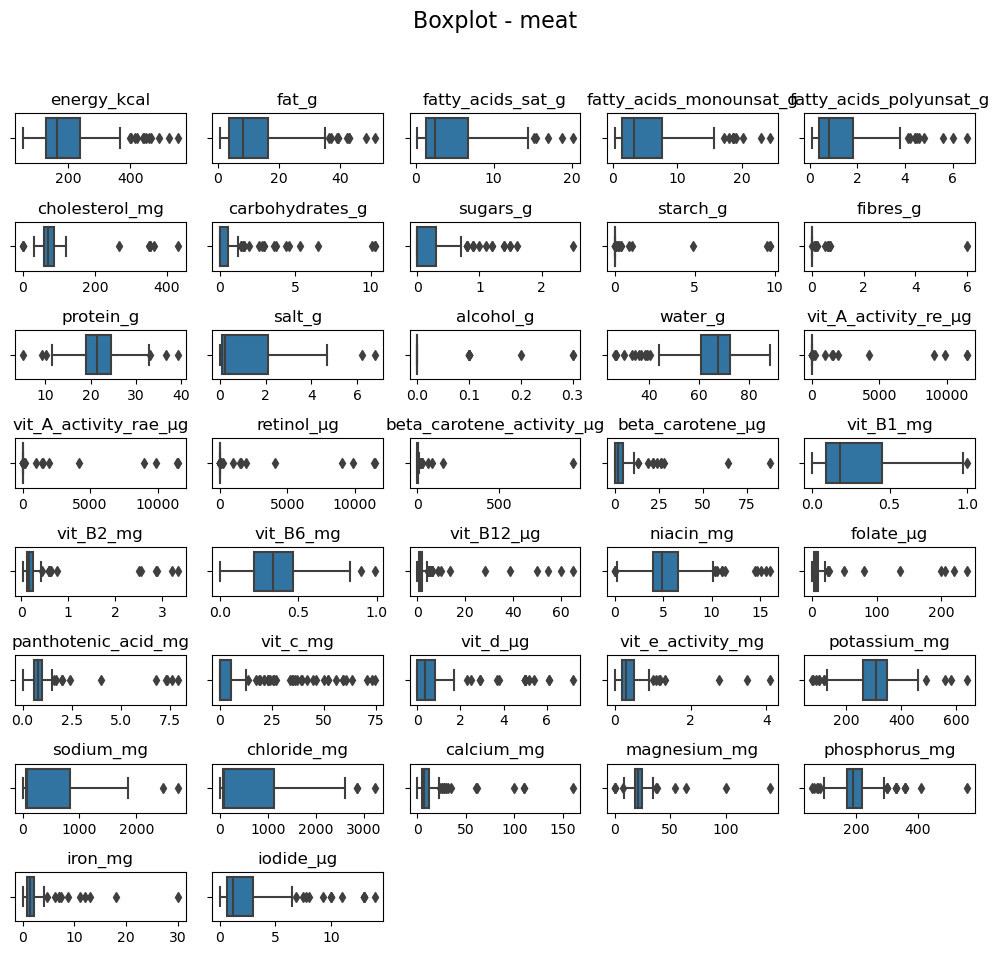

In [40]:
plot_distribution_of_features(dataset, 'meat', type='box', plot_title='Boxplot')

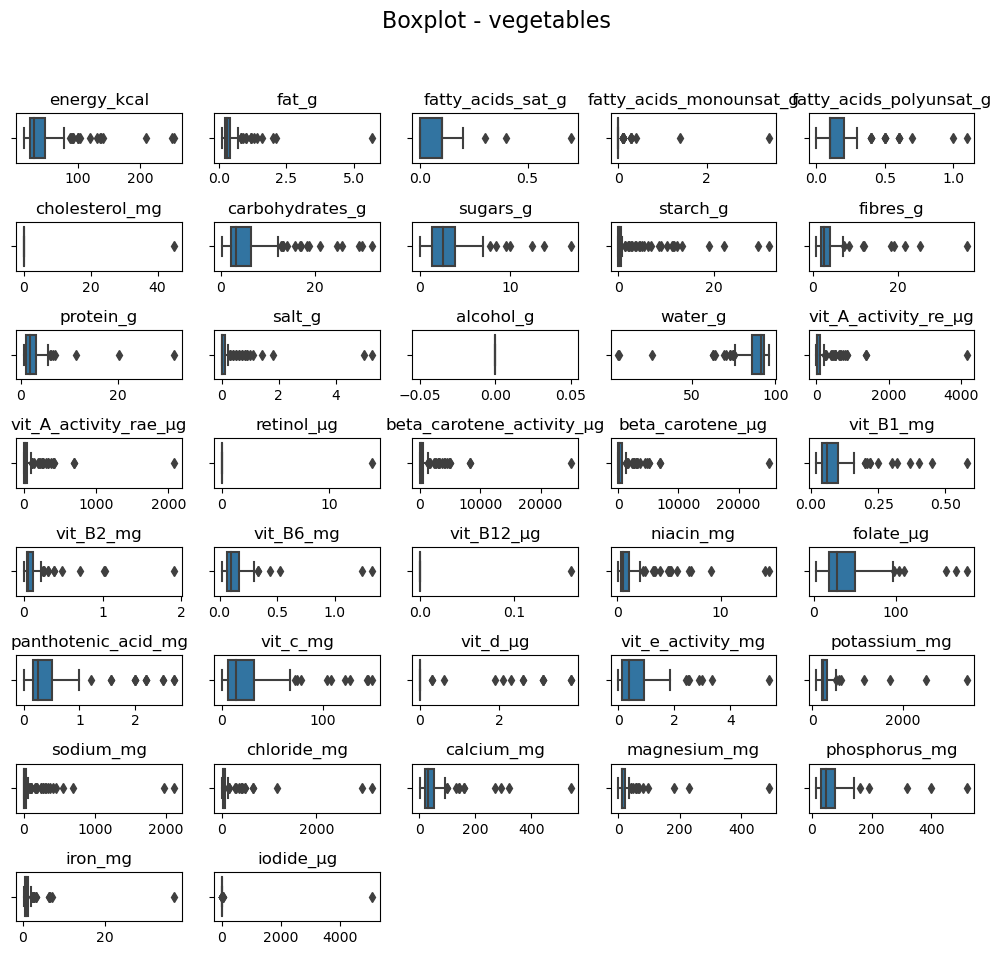

In [41]:
plot_distribution_of_features(dataset, 'vegetables', type='box', plot_title='Boxplot')

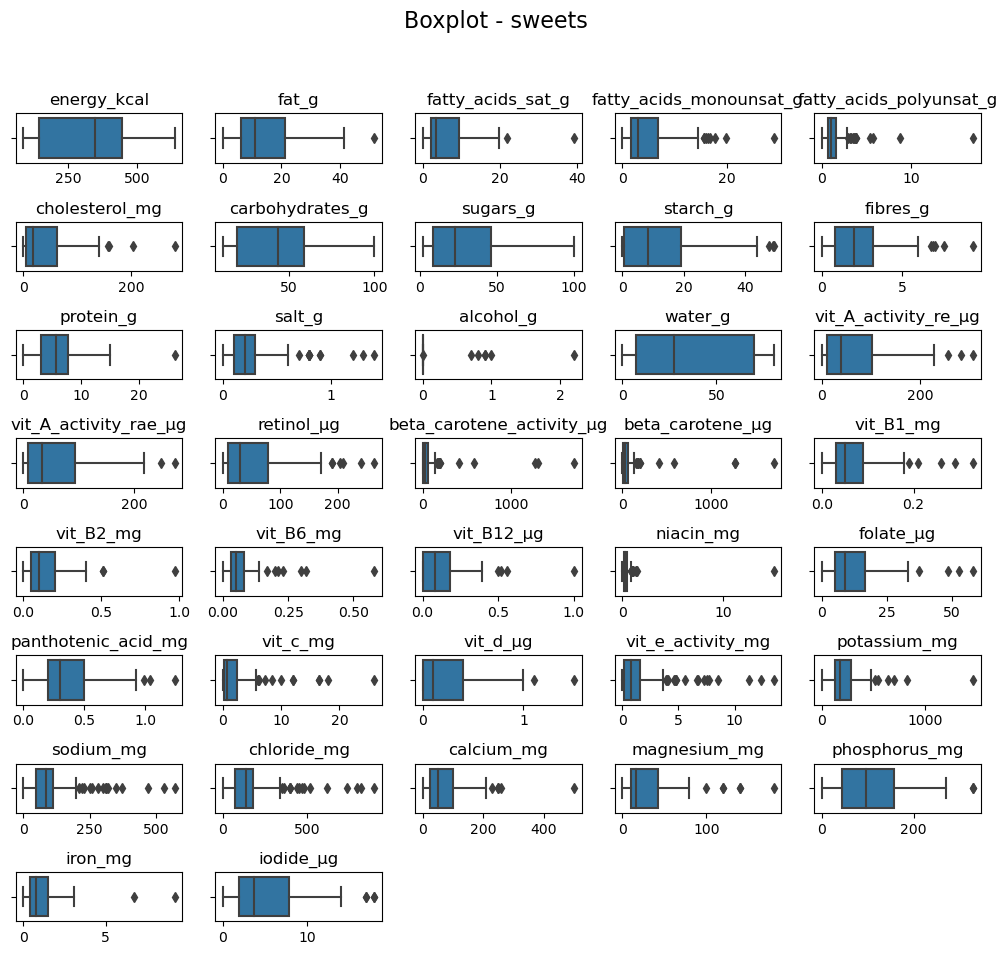

In [42]:
plot_distribution_of_features(dataset, 'sweets', type='box', plot_title='Boxplot')

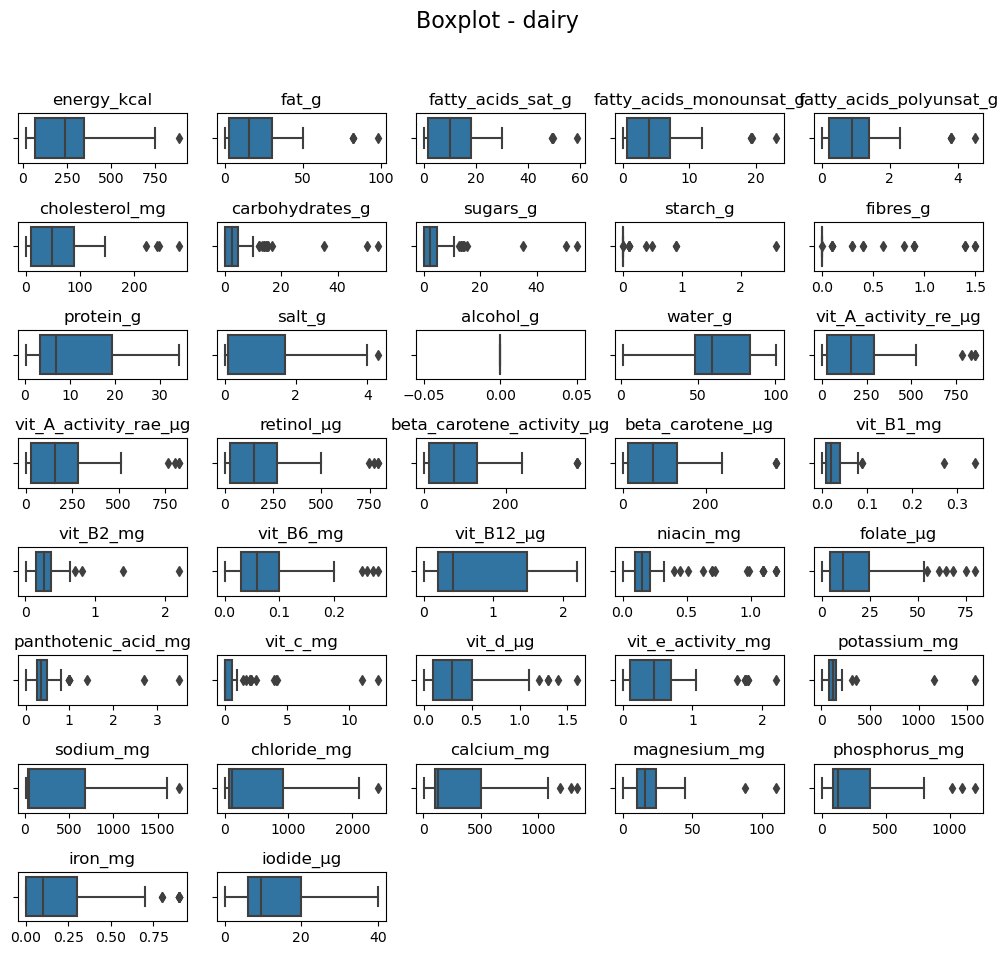

In [43]:
plot_distribution_of_features(dataset, 'dairy', type='box', plot_title='Boxplot')

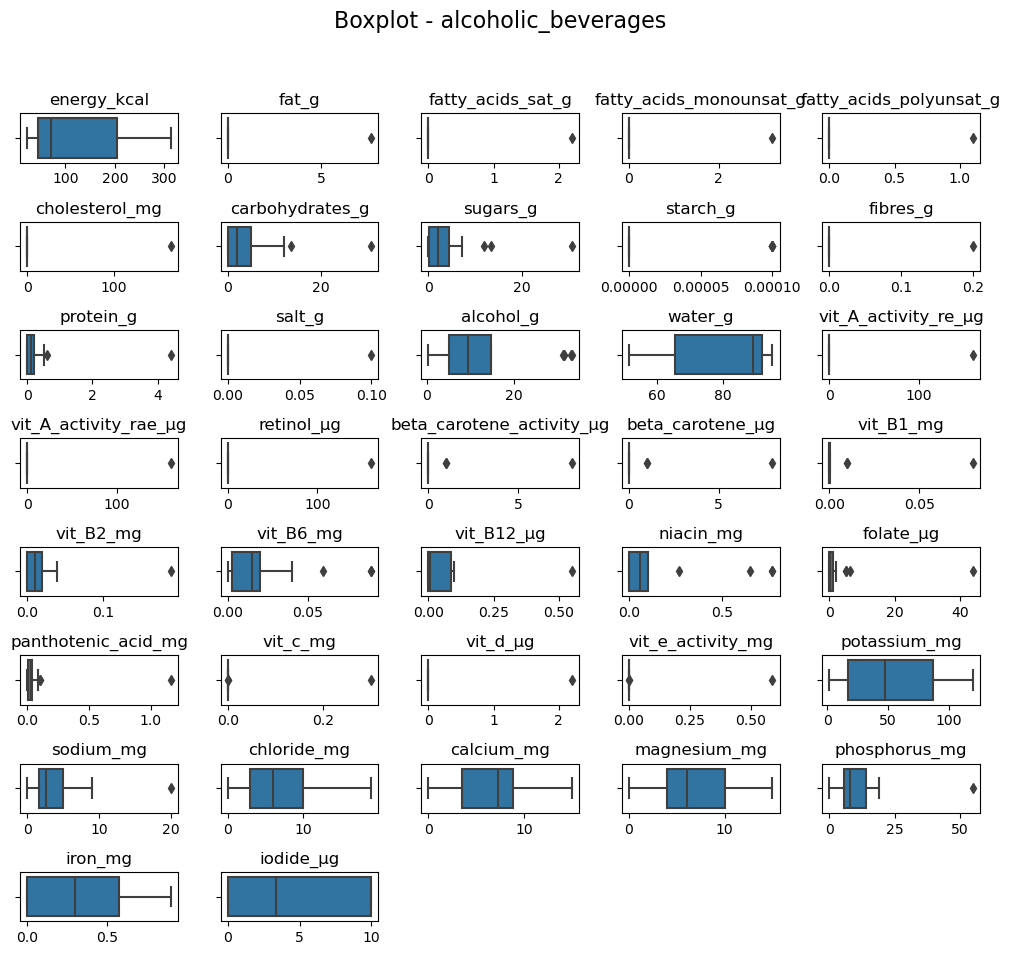

In [44]:
plot_distribution_of_features(dataset, 'alcoholic_beverages', type='box', plot_title='Boxplot')

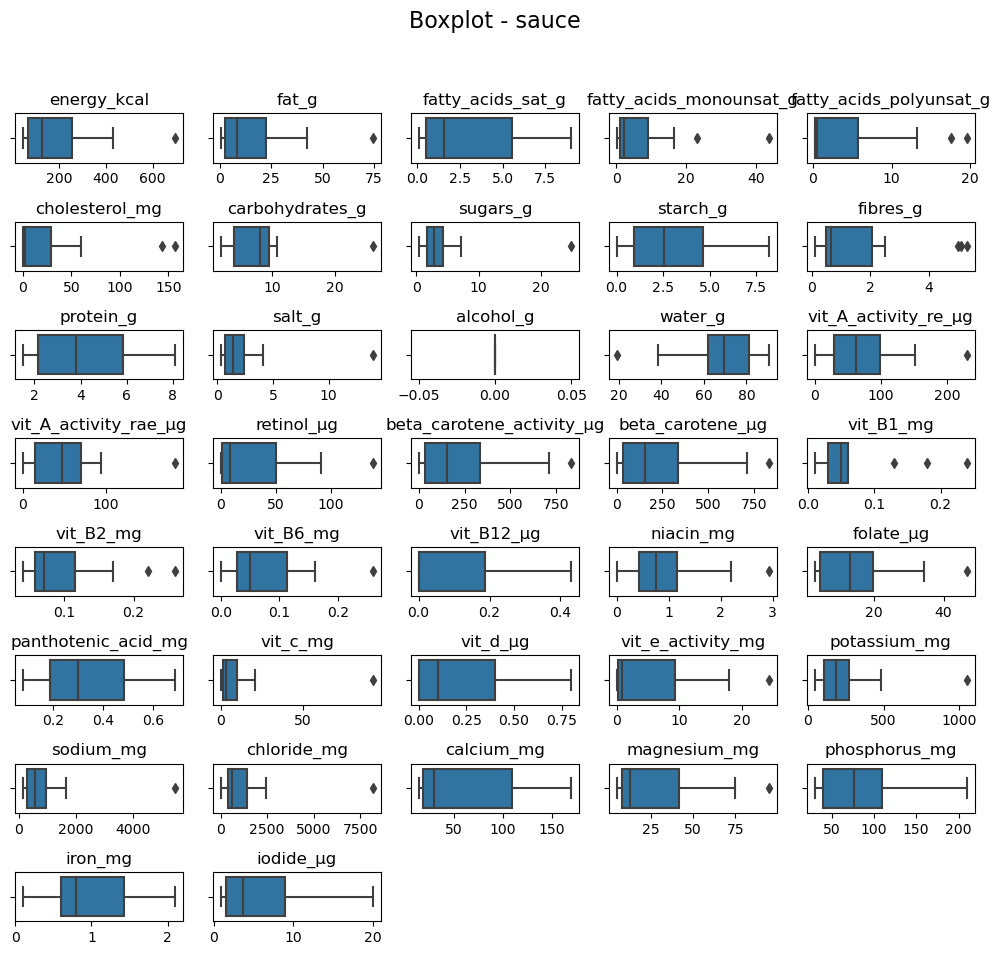

In [45]:
plot_distribution_of_features(dataset, 'sauce', type='box', plot_title='Boxplot')

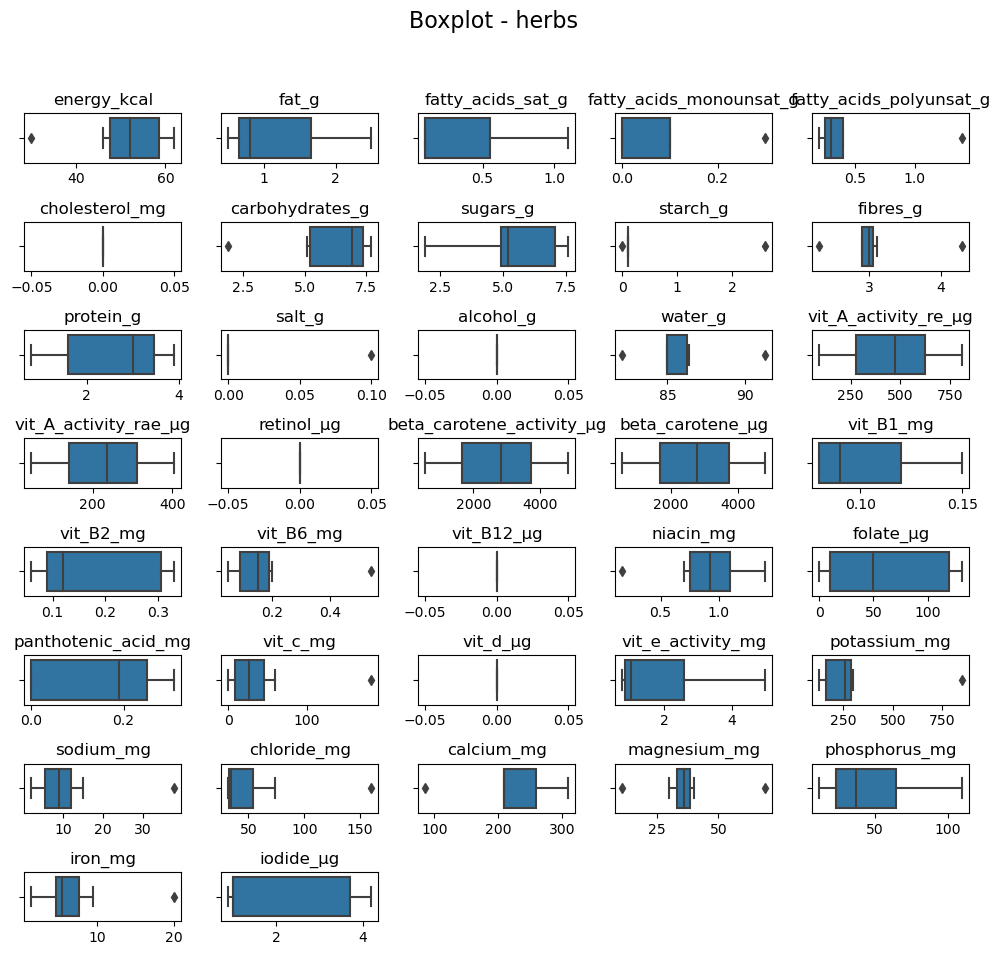

In [46]:
plot_distribution_of_features(dataset, 'herbs', type='box', plot_title='Boxplot')

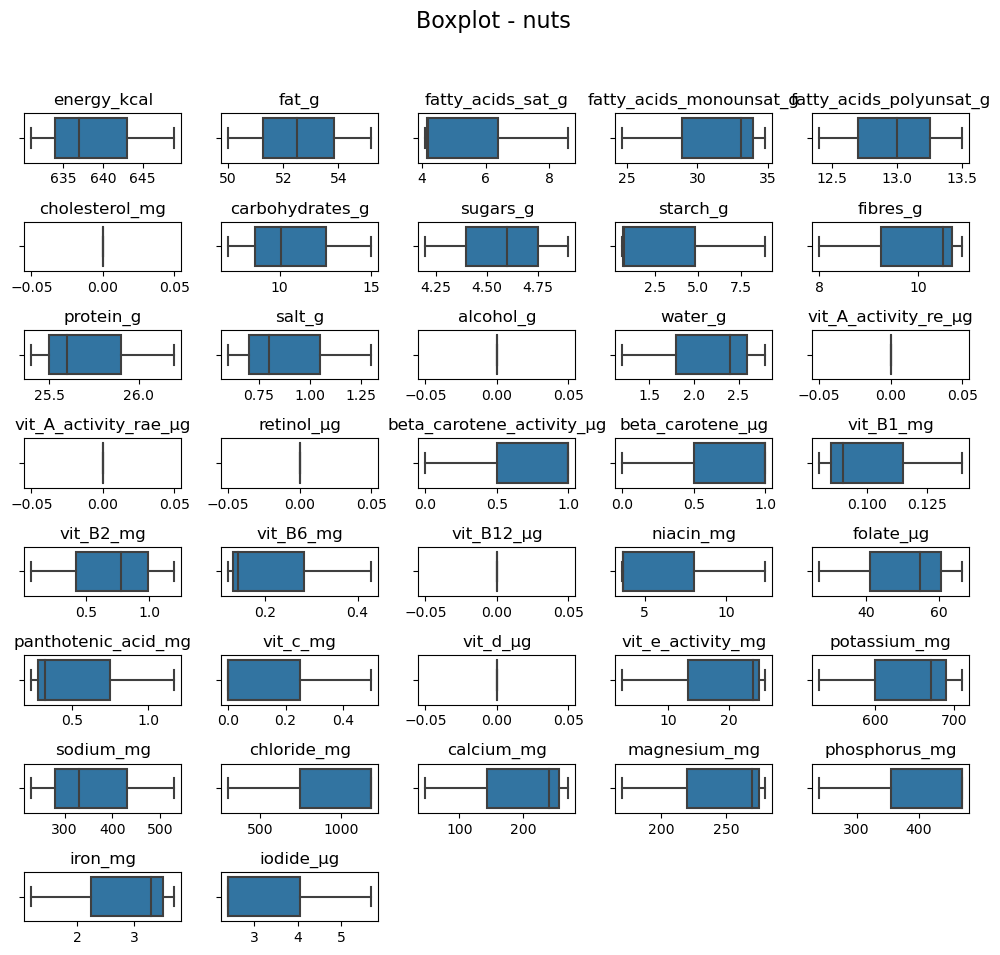

In [47]:
plot_distribution_of_features(dataset, 'nuts', type='box', plot_title='Boxplot')

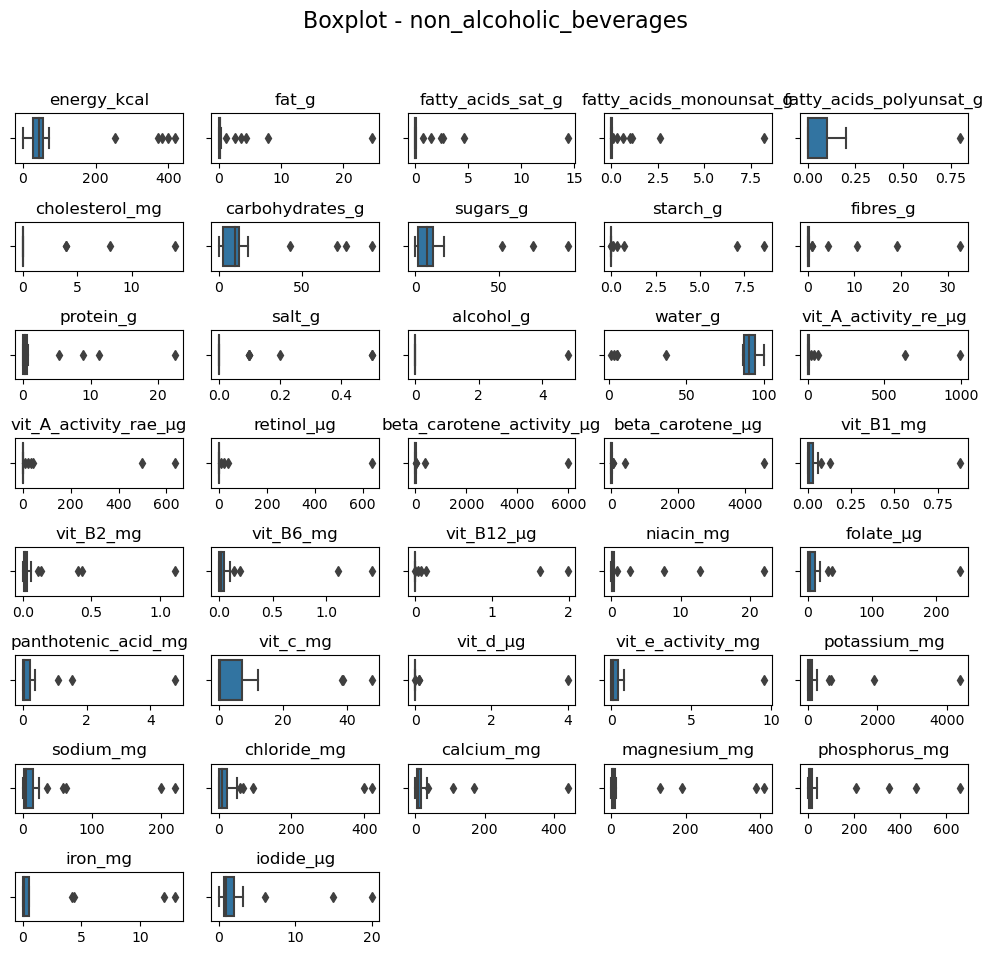

In [48]:
plot_distribution_of_features(dataset, 'non_alcoholic_beverages', type='box', plot_title='Boxplot')

Boxplots calculate the outliers via the interquartile range method (outliers will be the points that will be bigger than `third-quartile + 1.5*(inter-quartile-range)` or less than `first-quartile - 1.5*(inter-quartile-range)`).

## Approaches to deal with outliers

First try to remove them and see with how many samples would we be left.

In [49]:
len(dict_of_stats.keys()) # 444 combinations

444

In [54]:
dict_of_stats[('fruits', 'energy_kcal')]

((22.0, 594.0),
 [(624.0, 2),
  (698.0, 111),
  (681.0, 234),
  (661.0, 422),
  (623.0, 611),
  (688.0, 634),
  (615.0, 726),
  (612.0, 854),
  (619.0, 863),
  (660.0, 169),
  (621.0, 923),
  (709.0, 1020)])

In [50]:
set_of_outlier_indices = set()
for key in dict_of_stats.keys():
    for outlier_tuple in dict_of_stats[key][1]: # get only the index of the outlier
        set_of_outlier_indices.add(outlier_tuple[1]) # get only the position

print(f'There are {len(set_of_outlier_indices)} outliers.')

There are 641 outliers.


### Remove them

Just drop the outliers.

Out of 989 samples that do not have any missing values, 595 are classified as outliers. We will remove all these.

In [51]:
dataset_wihtout_outliers = dataset.drop(set_of_outlier_indices)
dataset_wihtout_outliers.shape

(443, 42)

Add the samples with missing values.

In [ ]:
dataset_wihtout_outliers_with_nans = pd.concat([dataset_wihtout_outliers, df_with_nan_only], axis=0)
dataset_wihtout_outliers_with_nans.shape

In [ ]:
plot_distribution_of_features(dataset_wihtout_outliers, 'dairy', type='box', plot_title='Boxplot')

### Subsitute their value with the max or min non-outlier value

In [ ]:
dataset_with_clipped_outliers = dataset.copy(deep=True)

for key in dict_of_stats.keys():
    feature = key[1]
    
    #extract the min and max values that are not outliers
    min_val = dict_of_stats[key][0][0]
    max_val = dict_of_stats[key][0][1]
    outliers_list = dict_of_stats[key][1]
    for outlier in outliers_list:
        outlier_idx = outlier[1]
        outlier_val = outlier[0]
        #print(f'Before setting the value {dataset_with_clipped_outliers.loc[outlier_idx, feature]} - {min_val}-{max_val}')
        dataset_with_clipped_outliers.loc[outlier_idx, feature] = min_val if outlier_val < min_val else max_val
        #print(f'{key}-{feature} - After setting the value {dataset_with_clipped_outliers.loc[outlier_idx, feature]}')

In [ ]:
dataset_with_clipped_outliers.shape

In [ ]:
plot_distribution_of_features(dataset, 'dairy', type='box', plot_title='Boxplot')

In [ ]:
plot_distribution_of_features(dataset_with_clipped_outliers, 'dairy', type='box', plot_title='Boxplot')